# Mediation analyses on brain signatures 

## Load everything

In [158]:
from pingouin import mediation_analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed
import numpy as np
np.random.seed(42)

# Load the data
base_dir = '~/data/PIC_conditioning_withinsub_nodatalad'# adjust to you base dir
data = pd.read_csv(base_dir + '/signatures.csv')

# rank  transform nps_nociception_pain_wager_2011 and siips2_extranociceptive_pain_woo_2017
#data['nps_nociception_pain_wager_2011'] = data['nps_nociception_pain_wager_2011'].rank()
#data['siips2_extranociceptive_pain_woo_2017'] = data['siips2_extranociceptive_pain_woo_2017'].rank()

# Exclude studies with insufficient data
exclude_studies = ["kessner", "ruetgen", "wager04a_princeton", "wager04b_michigan"]

# Define variables
# convert x to categorical and get integer representation
data['plc_induction'] = data['Conditioning'].astype('category').cat.codes
data['Rating_diff'] = -1*data['Rating_diff']   # higher score stronger placebo
# center explanatory variables
data['Rating_pain_ctr'] = data['Rating_pain_ctr'] - data['Rating_pain_ctr'].mean()
data['Age'] = data['Age'] - data['Age'].mean()
data['Male'] = data['Male'] - data['Male'].mean()

data.columns

Index(['Unnamed: 0', 'Study_ID', 'Sub_ID', 'Male', 'Age', 'NPS_pain_ctr',
       'Rating_pain_ctr', 'Rating_diff', 'Conditioning', 'TR', 'TE', 'FWHM',
       'Stim_Type', 'Stim_Dur', 'Stim_Side', 'Stim_Loc', 'Con_file',
       'nps_nociception_pain_wager_2011',
       'placebo_analgesia_anticip_wager_2011',
       'placebo_analgeisa_pain_wager_2011',
       'pines_negativeaffect_picture_chang_2015',
       'social_rejection_picture_woo_2014',
       'heartrate_social_threat_eisenbarth_2016',
       'skinconductance_social_threat_eisenbarth_2016',
       'vicarious_pain_picture_krishnan_2016',
       'empathy_care_listening_ashar_2017',
       'empathy_distress_listening_ashar_2017',
       'siips2_extranociceptive_pain_woo_2017',
       'pain_nociception_multistudy_kragel_2018',
       'negative_emotion_multistudy_kragel_2018',
       'cognitive_control_multistudy_kragel_2018',
       'threat_conditioning_acquisition_reddan_2018',
       'grbs_guilt_painresponsibility_yu_2019',
       

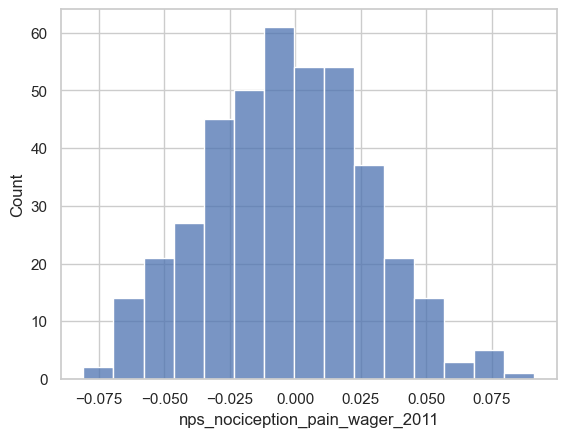

<Axes: xlabel='siips2_extranociceptive_pain_woo_2017', ylabel='Count'>

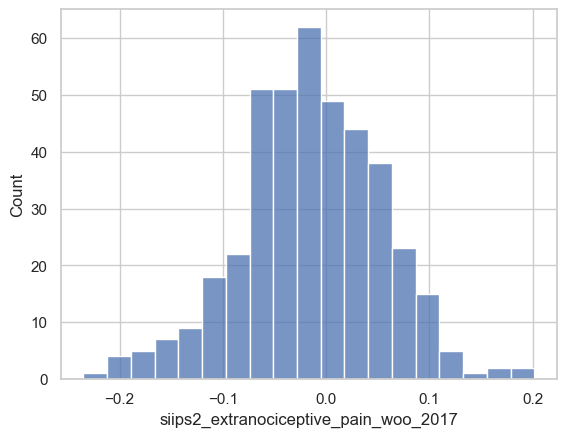

In [159]:
sns.histplot(data['nps_nociception_pain_wager_2011'])
plt.show()
sns.histplot(data['siips2_extranociceptive_pain_woo_2017'])

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_55208/1636943159.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.006896551724137931' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_55208/1636943159.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"]

plc_induction   -1.389815e-16
study_0         -8.686342e-18
study_5         -1.737268e-17
study_6         -3.474537e-17
study_12         5.211805e-17
study_13         0.000000e+00
study_1         -3.474537e-17
study_2          6.949073e-17
study_3          5.211805e-17
study_4          8.686342e-17
study_7          1.737268e-17
study_8          5.211805e-17
study_9          3.474537e-17
study_10        -6.080439e-17
study_11        -2.605902e-17
study_14         3.474537e-17
study_15         3.474537e-17
dtype: float64

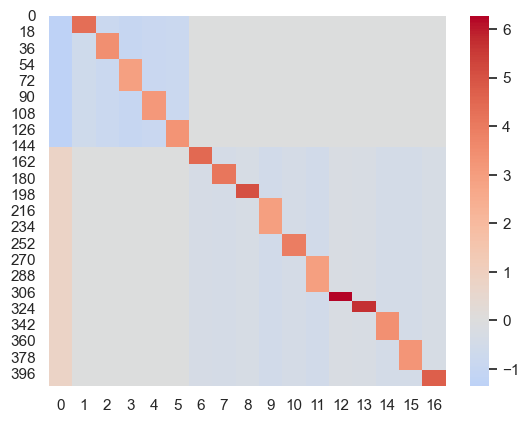

In [160]:
# create regression coded covariates for studies, being orthogonal to the "plc_induction" variable
# we do "simple coding", i.e. all regressors sum up to zero

def simple_coding(orig_pheno, sort=False):
    pheno = orig_pheno.copy()
    pheno['plc_induction'] = pheno['Conditioning'].astype('category').cat.codes
    # sort dataframe by induction type
    if sort:
        pheno = pheno.sort_values(by=['plc_induction', 'Study_ID'], inplace=False)

    # first we set 0 to -1 in induction type
    pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
    pheno.loc[pheno['plc_induction'] == 1, 'plc_induction'] = 1 / (pheno['plc_induction'] == 1).sum()
    # model studies
    pheno['study'] = pheno['Study_ID'].astype('category').cat.codes
    # create simple coded variables
    colnames = []
    for i in pheno['study'].unique():
        colnames.append(f'study_{i}')
        pheno[f'study_{i}'] = 0
        # which induction type does this study belong to
        induction_type = pheno.loc[pheno['study'] == i, 'plc_induction'].unique()[0]
        # number of participants in the study
        n_instudy = pheno.loc[pheno['study'] == i].shape[0]
        # number of participants not in the study, but being in the same induction type
        n_notinstudy_ind = pheno.loc[(pheno['study'] != i) & (pheno['plc_induction'] == induction_type)].shape[0]
        pheno[f'study_{i}'].loc[pheno['plc_induction'] == induction_type] = -1 / n_notinstudy_ind
        pheno[f'study_{i}'].loc[pheno['study'] == i] = 1 / n_instudy
    return pheno, colnames


# plot the design matrix
design_sorted, colnames = simple_coding(data, sort=True)
design_sorted = design_sorted[['plc_induction'] + colnames]
design_sorted /= design_sorted.std()
sns.heatmap(design_sorted.to_numpy(), cmap='coolwarm', center=0)
# column means
design_sorted.mean()

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_55208/1636943159.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.006896551724137931' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_55208/1636943159.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"]

plc_induction   -4.343171e-17
study_0          0.000000e+00
study_1         -1.042361e-16
study_2          6.949073e-17
study_3          1.737268e-17
study_4          3.474537e-17
study_5         -1.042361e-16
study_6         -6.949073e-17
study_7         -3.474537e-17
study_8          6.949073e-17
study_9          3.474537e-17
study_10        -2.605902e-17
study_11        -1.737268e-17
study_12         3.474537e-17
study_13         0.000000e+00
study_14        -5.211805e-17
study_15         3.474537e-17
dtype: float64

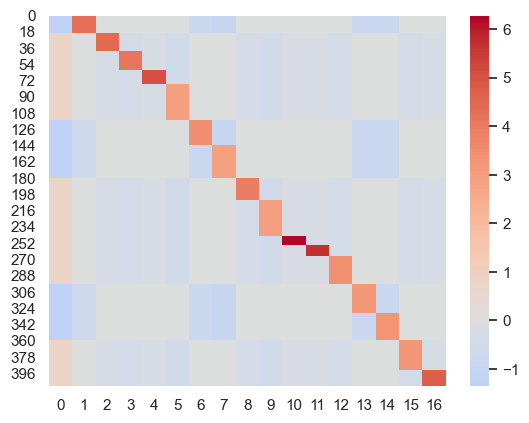

In [161]:
# The previous one was sorted for visualization purposes, here's the one to be used for the analyses
# plot the design matrix
design, colnames = simple_coding(data, sort=False)
design[['plc_induction'] + colnames] /= design[['plc_induction'] + colnames].std()
sns.heatmap(design[['plc_induction'] + colnames].to_numpy(), cmap='coolwarm', center=0)
# column means
design[['plc_induction'] + colnames].mean()

In [162]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Assuming `data` is a DataFrame already loaded with the relevant data

# Adding interaction term directly in the formula
formula = 'nps_nociception_pain_wager_2011 ~ plc_induction * Rating_diff + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames)

# Fit linear model using formula API
model = smf.ols(formula=formula, data=design).fit()
print(model.summary())

# Function to fit the model and return the t-score for plc_induction
def bootstrap_tscore(data, formula, n_iterations=1000, n_jobs=-1):
    def fit_model(data):
        sample = resample(data)
        model = smf.ols(formula=formula, data=sample).fit()
        return model.params

    # Run bootstrap in parallel
    tscores = Parallel(n_jobs=n_jobs)(delayed(fit_model)(design) for _ in range(n_iterations))

    return np.array(tscores)

# Perform bootstrap analysis
n_iterations = 10000  # Number of bootstrap samples
n_jobs = -1  # Use all available CPUs

bootstrap_tscores = bootstrap_tscore(data, formula, n_iterations, n_jobs)

# Analyze the bootstrap t-scores
bootstrap_pval = np.mean(bootstrap_tscores>0, axis=0)
bootstrap_tscore_ci = np.percentile(bootstrap_tscores, [2.5, 97.5], axis=0)

pd.DataFrame({'p_boot': bootstrap_pval, 
              'ci_boot_lower': bootstrap_tscore_ci[0,:],
              'ci_boot_upper': bootstrap_tscore_ci[1,:]}, index=model.params.index)

                                   OLS Regression Results                                  
Dep. Variable:     nps_nociception_pain_wager_2011   R-squared:                       0.104
Model:                                         OLS   Adj. R-squared:                  0.058
Method:                              Least Squares   F-statistic:                     2.253
Date:                             Wed, 07 Aug 2024   Prob (F-statistic):            0.00170
Time:                                     14:02:30   Log-Likelihood:                 865.79
No. Observations:                              409   AIC:                            -1690.
Df Residuals:                                  388   BIC:                            -1605.
Df Model:                                       20                                         
Covariance Type:                         nonrobust                                         
                                coef    std err          t      P>|t|      [0.02

,p_boot,ci_boot_lower,ci_boot_upper
Intercept,0.7154,-0.002774,0.004845
plc_induction,0.5218,-0.003586,0.003830
Rating_diff,0.0006,-0.000607,-0.000153
plc_induction:Rating_diff,0.0312,-0.000348,0.000009
Rating_pain_ctr,0.2144,-0.000230,0.000098
Age,0.0120,-0.001080,-0.000073
Male,0.4977,-0.007217,0.007065
study_0,0.7403,-0.001644,0.003046
study_1,0.1842,-0.004183,0.001376
study_2,0.8319,-0.001165,0.003366


In [152]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Assuming `data` is a DataFrame already loaded with the relevant data

INST_only = design[design['plc_induction']<0]
INST_only_colnames = [cn for cn in colnames if INST_only[cn].sum() != 0]
# Adding interaction term directly in the formula
formula = 'nps_nociception_pain_wager_2011 ~ Rating_diff + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(INST_only_colnames)

# Fit linear model using formula API
model = smf.ols(formula=formula, data=INST_only).fit()
print(model.summary())

# Function to fit the model and return the t-score for plc_induction
def bootstrap_tscore(data, formula, n_iterations=1000, n_jobs=-1):
    def fit_model(data):
        sample = resample(data)
        model = smf.ols(formula=formula, data=sample).fit()
        return model.params

    # Run bootstrap in parallel
    tscores = Parallel(n_jobs=n_jobs)(delayed(fit_model)(data) for _ in range(n_iterations))

    return np.array(tscores)

# Perform bootstrap analysis
n_iterations = 10000  # Number of bootstrap samples
n_jobs = -1  # Use all available CPUs

bootstrap_tscores = bootstrap_tscore(INST_only, formula, n_iterations, n_jobs)

# Analyze the bootstrap t-scores
bootstrap_pval = np.mean(bootstrap_tscores>0, axis=0)
bootstrap_tscore_ci = np.percentile(bootstrap_tscores, [2.5, 97.5], axis=0)

pd.DataFrame({'p_boot': bootstrap_pval, 
              'ci_boot_lower': bootstrap_tscore_ci[0,:],
              'ci_boot_upper': bootstrap_tscore_ci[1,:]}, index=model.params.index)

                                   OLS Regression Results                                  
Dep. Variable:     nps_nociception_pain_wager_2011   R-squared:                       0.058
Model:                                         OLS   Adj. R-squared:                  0.002
Method:                              Least Squares   F-statistic:                     1.044
Date:                             Thu, 01 Aug 2024   Prob (F-statistic):              0.406
Time:                                     18:25:32   Log-Likelihood:                 309.13
No. Observations:                              145   AIC:                            -600.3
Df Residuals:                                  136   BIC:                            -573.5
Df Model:                                        8                                         
Covariance Type:                         nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.9

,p_boot,ci_boot_lower,ci_boot_upper
Intercept,0.5999,-0.005080,0.006812
Rating_diff,0.1251,-0.000372,0.000122
Rating_pain_ctr,0.2473,-0.000307,0.000138
Age,0.1032,-0.001012,0.000219
Male,0.5867,-0.009730,0.011613
study_0,0.7672,-0.001547,0.003250
study_5,0.6228,-0.002372,0.003226
study_6,0.1035,-0.003249,0.000738
study_12,0.0466,-0.004282,0.000320
study_13,0.9458,-0.000464,0.004930


In [154]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Assuming `data` is a DataFrame already loaded with the relevant data

CONDINST = design[design['plc_induction']>0]
CONDINST_colnames = [cn for cn in colnames if CONDINST[cn].sum() != 0]
# Adding interaction term directly in the formula
formula = 'nps_nociception_pain_wager_2011 ~ Rating_diff + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(CONDINST_colnames)

# Fit linear model using formula API
model = smf.ols(formula=formula, data=CONDINST).fit()
print(model.summary())

# Function to fit the model and return the t-score for plc_induction
def bootstrap_tscore(data, formula, n_iterations=1000, n_jobs=-1):
    def fit_model(data):
        sample = resample(data)
        model = smf.ols(formula=formula, data=sample).fit()
        return model.params

    # Run bootstrap in parallel
    tscores = Parallel(n_jobs=n_jobs)(delayed(fit_model)(data) for _ in range(n_iterations))

    return np.array(tscores)

# Perform bootstrap analysis
n_iterations = 10000  # Number of bootstrap samples
n_jobs = -1  # Use all available CPUs

bootstrap_tscores = bootstrap_tscore(CONDINST, formula, n_iterations, n_jobs)

# Analyze the bootstrap t-scores
bootstrap_pval = np.mean(bootstrap_tscores>0, axis=0)
bootstrap_tscore_ci = np.percentile(bootstrap_tscores, [2.5, 97.5], axis=0)

pd.DataFrame({'p_boot': bootstrap_pval, 
              'ci_boot_lower': bootstrap_tscore_ci[0,:],
              'ci_boot_upper': bootstrap_tscore_ci[1,:]}, index=model.params.index)

                                   OLS Regression Results                                  
Dep. Variable:     nps_nociception_pain_wager_2011   R-squared:                       0.089
Model:                                         OLS   Adj. R-squared:                  0.049
Method:                              Least Squares   F-statistic:                     2.236
Date:                             Thu, 01 Aug 2024   Prob (F-statistic):             0.0132
Time:                                     18:26:09   Log-Likelihood:                 551.70
No. Observations:                              264   AIC:                            -1079.
Df Residuals:                                  252   BIC:                            -1036.
Df Model:                                       11                                         
Covariance Type:                         nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.9

,p_boot,ci_boot_lower,ci_boot_upper
Intercept,0.5777,-0.004687,0.005533
Rating_diff,0.0023,-0.000772,-0.000134
Rating_pain_ctr,0.3383,-0.000305,0.000202
Age,0.0235,-0.001851,-0.000022
Male,0.3914,-0.011121,0.008343
study_1,0.2421,-0.004889,0.002113
study_2,0.8372,-0.001547,0.004596
study_4,0.7613,-0.002471,0.005318
study_8,0.9348,-0.000799,0.006000
study_9,0.7878,-0.002288,0.005329


In [ ]:
# siips2_extranociceptive_pain_woo_2017

In [155]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Assuming `data` is a DataFrame already loaded with the relevant data

# Adding interaction term directly in the formula
formula = 'siips2_extranociceptive_pain_woo_2017 ~ plc_induction * Rating_diff  + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames)

# Fit linear model using formula API
model = smf.ols(formula=formula, data=design).fit()
print(model.summary())

# Function to fit the model and return the t-score for plc_induction
def bootstrap_tscore(data, formula, n_iterations=1000, n_jobs=-1):
    def fit_model(data):
        sample = resample(data)
        model = smf.ols(formula=formula, data=sample).fit()
        return model.params

    # Run bootstrap in parallel
    tscores = Parallel(n_jobs=n_jobs)(delayed(fit_model)(design) for _ in range(n_iterations))

    return np.array(tscores)

# Perform bootstrap analysis
n_iterations = 10000  # Number of bootstrap samples
n_jobs = -1  # Use all available CPUs

bootstrap_tscores = bootstrap_tscore(data, formula, n_iterations, n_jobs)

# Analyze the bootstrap t-scores
bootstrap_pval = np.mean(bootstrap_tscores>0, axis=0)
bootstrap_tscore_ci = np.percentile(bootstrap_tscores, [2.5, 97.5], axis=0)

pd.DataFrame({'p_boot': bootstrap_pval, 
              'ci_boot_lower': bootstrap_tscore_ci[0,:],
              'ci_boot_upper': bootstrap_tscore_ci[1,:]}, index=model.params.index)

                                      OLS Regression Results                                     
Dep. Variable:     siips2_extranociceptive_pain_woo_2017   R-squared:                       0.086
Model:                                               OLS   Adj. R-squared:                  0.039
Method:                                    Least Squares   F-statistic:                     1.823
Date:                                   Thu, 01 Aug 2024   Prob (F-statistic):             0.0170
Time:                                           18:26:24   Log-Likelihood:                 535.87
No. Observations:                                    409   AIC:                            -1030.
Df Residuals:                                        388   BIC:                            -945.4
Df Model:                                             20                                         
Covariance Type:                               nonrobust                                         
                    

,p_boot,ci_boot_lower,ci_boot_upper
Intercept,0.0742,-0.015266,0.002264
plc_induction,0.3594,-0.010081,0.006520
Rating_diff,0.0038,-0.001331,-0.000193
plc_induction:Rating_diff,0.1445,-0.000702,0.000220
Rating_pain_ctr,0.2801,-0.000477,0.000264
Age,0.4381,-0.001336,0.001135
Male,0.3432,-0.019483,0.012818
study_0,0.2452,-0.005789,0.002783
study_1,0.1593,-0.011684,0.003684
study_2,0.9486,-0.000889,0.009371


In [156]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Assuming `data` is a DataFrame already loaded with the relevant data

INST_only = design[design['plc_induction']<0]
INST_only_colnames = [cn for cn in colnames if INST_only[cn].sum() != 0]
# Adding interaction term directly in the formula
formula = 'siips2_extranociceptive_pain_woo_2017 ~ Rating_diff  + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(INST_only_colnames)

# Fit linear model using formula API
model = smf.ols(formula=formula, data=INST_only).fit()
print(model.summary())

# Function to fit the model and return the t-score for plc_induction
def bootstrap_tscore(data, formula, n_iterations=1000, n_jobs=-1):
    def fit_model(data):
        sample = resample(data)
        model = smf.ols(formula=formula, data=sample).fit()
        return model.params

    # Run bootstrap in parallel
    tscores = Parallel(n_jobs=n_jobs)(delayed(fit_model)(data) for _ in range(n_iterations))

    return np.array(tscores)

# Perform bootstrap analysis
n_iterations = 10000  # Number of bootstrap samples
n_jobs = -1  # Use all available CPUs

bootstrap_tscores = bootstrap_tscore(INST_only, formula, n_iterations, n_jobs)

# Analyze the bootstrap t-scores
bootstrap_pval = np.mean(bootstrap_tscores>0, axis=0)
bootstrap_tscore_ci = np.percentile(bootstrap_tscores, [2.5, 97.5], axis=0)

pd.DataFrame({'p_boot': bootstrap_pval, 
              'ci_boot_lower': bootstrap_tscore_ci[0,:],
              'ci_boot_upper': bootstrap_tscore_ci[1,:]}, index=model.params.index)

                                      OLS Regression Results                                     
Dep. Variable:     siips2_extranociceptive_pain_woo_2017   R-squared:                       0.046
Model:                                               OLS   Adj. R-squared:                 -0.010
Method:                                    Least Squares   F-statistic:                    0.8192
Date:                                   Thu, 01 Aug 2024   Prob (F-statistic):              0.587
Time:                                           18:26:44   Log-Likelihood:                 198.47
No. Observations:                                    145   AIC:                            -378.9
Df Residuals:                                        136   BIC:                            -352.1
Df Model:                                              8                                         
Covariance Type:                               nonrobust                                         
                    

,p_boot,ci_boot_lower,ci_boot_upper
Intercept,0.3091,-0.015094,0.009012
Rating_diff,0.0502,-0.001073,0.000102
Rating_pain_ctr,0.5232,-0.000483,0.000504
Age,0.6547,-0.001066,0.001556
Male,0.6941,-0.017815,0.029657
study_0,0.2359,-0.005857,0.002851
study_5,0.2937,-0.006611,0.003923
study_6,0.7634,-0.002794,0.005999
study_12,0.3187,-0.007492,0.004496
study_13,0.8080,-0.003228,0.007992


In [157]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Assuming `data` is a DataFrame already loaded with the relevant data

CONDINST = design[design['plc_induction']>0]
CONDINST_colnames = [cn for cn in colnames if CONDINST[cn].sum() != 0]
# Adding interaction term directly in the formula
formula = 'siips2_extranociceptive_pain_woo_2017 ~ Rating_diff  + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(CONDINST_colnames)

# Fit linear model using formula API
model = smf.ols(formula=formula, data=CONDINST).fit()
print(model.summary())

# Function to fit the model and return the t-score for plc_induction
def bootstrap_tscore(data, formula, n_iterations=1000, n_jobs=-1):
    def fit_model(data):
        sample = resample(data)
        model = smf.ols(formula=formula, data=sample).fit()
        return model.params

    # Run bootstrap in parallel
    tscores = Parallel(n_jobs=n_jobs)(delayed(fit_model)(data) for _ in range(n_iterations))

    return np.array(tscores)

# Perform bootstrap analysis
n_iterations = 10000  # Number of bootstrap samples
n_jobs = -1  # Use all available CPUs

bootstrap_tscores = bootstrap_tscore(CONDINST, formula, n_iterations, n_jobs)

# Analyze the bootstrap t-scores
bootstrap_pval = np.mean(bootstrap_tscores>0, axis=0)
bootstrap_tscore_ci = np.percentile(bootstrap_tscores, [2.5, 97.5], axis=0)

pd.DataFrame({'p_boot': bootstrap_pval, 
              'ci_boot_lower': bootstrap_tscore_ci[0,:],
              'ci_boot_upper': bootstrap_tscore_ci[1,:]}, index=model.params.index)

                                      OLS Regression Results                                     
Dep. Variable:     siips2_extranociceptive_pain_woo_2017   R-squared:                       0.086
Model:                                               OLS   Adj. R-squared:                  0.046
Method:                                    Least Squares   F-statistic:                     2.159
Date:                                   Thu, 01 Aug 2024   Prob (F-statistic):             0.0172
Time:                                           18:26:59   Log-Likelihood:                 336.79
No. Observations:                                    264   AIC:                            -649.6
Df Residuals:                                        252   BIC:                            -606.7
Df Model:                                             11                                         
Covariance Type:                               nonrobust                                         
                    

,p_boot,ci_boot_lower,ci_boot_upper
Intercept,0.0715,-0.022188,0.002835
Rating_diff,0.0188,-0.001588,-0.000051
Rating_pain_ctr,0.2250,-0.000852,0.000356
Age,0.2920,-0.002926,0.001898
Male,0.3219,-0.025854,0.015922
study_1,0.1224,-0.015162,0.003692
study_2,0.8226,-0.003533,0.010055
study_4,0.2701,-0.011529,0.005995
study_8,0.8751,-0.003363,0.013422
study_9,0.0772,-0.015404,0.002112


/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 18 with 20 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 18 with 20 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 18 with 20 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the 

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,nps_nociception_pain_wager_2011 ~ X,-0.002010,0.001565,0.199993,-0.005087,0.001068,No
1,Y ~ nps_nociception_pain_wager_2011,-98.127974,27.319286,0.000370,-151.839048,-44.416899,Yes
2,Total,1.031442,0.859691,0.230950,-0.658753,2.721637,No
3,Direct,0.837766,0.849218,0.324492,-0.831851,2.507384,No
4,Indirect,0.193676,0.176894,0.196000,-0.066904,0.651231,No


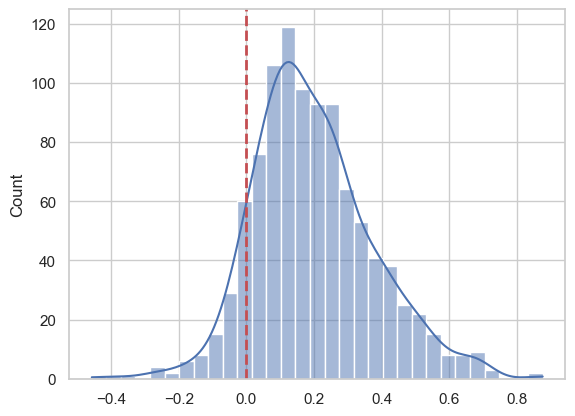

In [136]:
stats, dist = mediation_analysis(data=design, x='plc_induction', m='nps_nociception_pain_wager_2011', y='Rating_diff',
                                 covar=['Age', 'Male'] + colnames, 
                                 n_boot=1000,
                                 alpha=0.05, seed=42, return_dist=True)
sns.histplot(dist, kde=True)
plt.axvline(0, color='r', linestyle='dashed', linewidth=2)
stats

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 18 with 20 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 18 with 20 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the other columns.
  warnings.warn(
/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/pingouin/regression.py:420: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 18 with 20 columns). That means that one or more of the columns in `X` are a linear combination of one of more of the 

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,siips2_extranociceptive_pain_woo_2017 ~ X,-0.004903,0.003493,0.161162,-0.011771,0.001964,No
1,Y ~ siips2_extranociceptive_pain_woo_2017,-42.291979,12.253491,0.000618,-66.382951,-18.201006,Yes
2,Total,1.031442,0.859691,0.230950,-0.658753,2.721637,No
3,Direct,0.828220,0.850637,0.330835,-0.844187,2.500627,No
4,Indirect,0.203222,0.171819,0.172000,-0.039770,0.650931,No


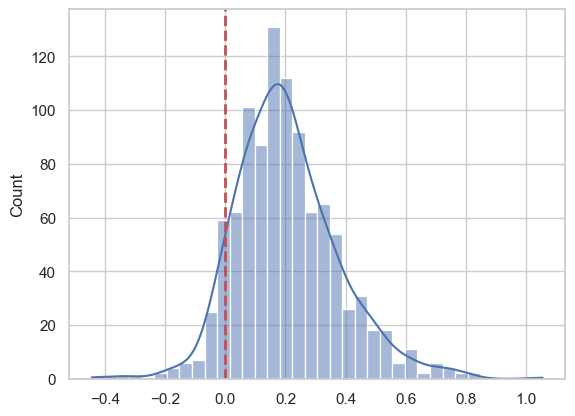

In [138]:
stats, dist = mediation_analysis(data=design, x='plc_induction', m='siips2_extranociceptive_pain_woo_2017', y='Rating_diff',
                                 covar=['Age', 'Male'] + colnames, 
                                 alpha=0.05, n_boot=1000, seed=42, return_dist=True)
sns.histplot(dist, kde=True)
plt.axvline(0, color='r', linestyle='dashed', linewidth=2)
stats


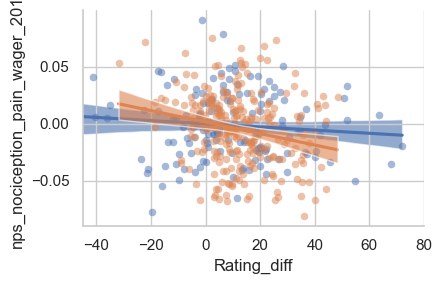

In [111]:
sns.set(style="whitegrid")

# Plot data with jitter and summary statistics
sns.lmplot(y='nps_nociception_pain_wager_2011', x='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), 
           scatter_kws={'alpha':0.5, 's':30, 'linewidths': 0}, 
           line_kws={'alpha': 1},
           legend=False, height=3, aspect=1.5)
plt.setp(plt.gca().collections[1], alpha=0.6, zorder=-10)
plt.setp(plt.gca().collections[3], alpha=0.6, zorder=10)
plt.xlim(-45, 80)
plt.savefig('../fig/nps.pdf')

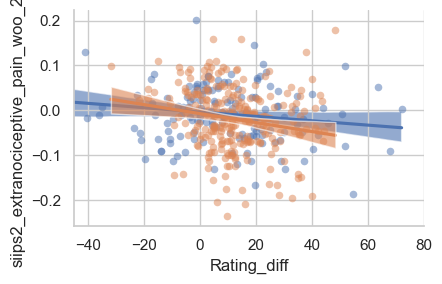

In [112]:
sns.set(style="whitegrid")

# Plot data with jitter and summary statistics
sns.lmplot(y='siips2_extranociceptive_pain_woo_2017', x='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), 
           scatter_kws={'alpha':0.5, 's':30, 'linewidths': 0}, 
           line_kws={'alpha': 1},
           legend=False, height=3, aspect=1.5)
plt.setp(plt.gca().collections[1], alpha=0.6, zorder=-10)
plt.setp(plt.gca().collections[3], alpha=0.6, zorder=10)
plt.xlim(-45, 80)
plt.savefig('../fig/siips.pdf')